In [1]:
import numpy as np
import pandas as pd

# Load weights from CSV file
weights = np.loadtxt('fc3_weights.csv', delimiter=',')

# Constants for normalization
G_max, G_min = 0.000003169003, 0.0000006706055
n = 1  # Define your multiplier for standard deviation normalization

# Compute mean and standard deviation
mean_weight = np.mean(weights)
std_weight = np.std(weights)

# Initialize normalized weight matrices
W_positive = np.maximum(weights, 0)
W_negative = -np.minimum(weights, 0)

# Apply normalization method (Eq. 11)
normalized_weights = np.zeros_like(weights)
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        w = weights[i, j]
        if w > mean_weight + n * std_weight:
            normalized_weights[i, j] = 1
        elif mean_weight - n * std_weight < w < 0:
            normalized_weights[i, j] = w / (mean_weight - n * std_weight)
        elif 0 < w < mean_weight + n * std_weight:
            normalized_weights[i, j] = w / (mean_weight + n * std_weight)
        elif w < mean_weight - n * std_weight:
            normalized_weights[i, j] = -1

# Save normalized weights for reference
np.savetxt('normalized2_weights.csv', normalized_weights, delimiter=',')
print("Normalized weights saved to 'normalized2_weights.csv'.")

# Split normalized weights into positive and negative components
W_norm_positive = np.maximum(normalized_weights, 0)
W_norm_negative = -np.minimum(normalized_weights, 0)

# Map normalized weights to conductance range
G_positive = W_norm_positive * (G_max - G_min) + G_min
G_negative = W_norm_negative * (G_max - G_min) + G_min

# Prepare DataFrames with labels
labels = [f'Label_{i}' for i in range(G_positive.shape[0])]
G_positive_df = pd.DataFrame(G_positive.T)
G_positive_df.columns = labels
G_positive_df.loc[-1] = labels
G_positive_df.index = G_positive_df.index + 1
G_positive_df = G_positive_df.sort_index()

G_negative_df = pd.DataFrame(G_negative.T)
G_negative_df.columns = labels
G_negative_df.loc[-1] = labels
G_negative_df.index = G_negative_df.index + 1
G_negative_df = G_negative_df.sort_index()

# Save conductance matrices to CSV files
G_positive_df.to_csv('2conductance_positive_ann_v3.csv', index=False)
G_negative_df.to_csv('2conductance_negative_ann_v3.csv', index=False)
print("Conductance matrices saved with labels in '2conductance_positive_ann_v3.csv' and '2conductance_negative_ann_v3.csv'.")


Normalized weights saved to 'normalized2_weights.csv'.
Conductance matrices saved with labels in '2conductance_positive_ann_v3.csv' and '2conductance_negative_ann_v3.csv'.


Plot saved as 'figure8_result_plot_avg2.png'


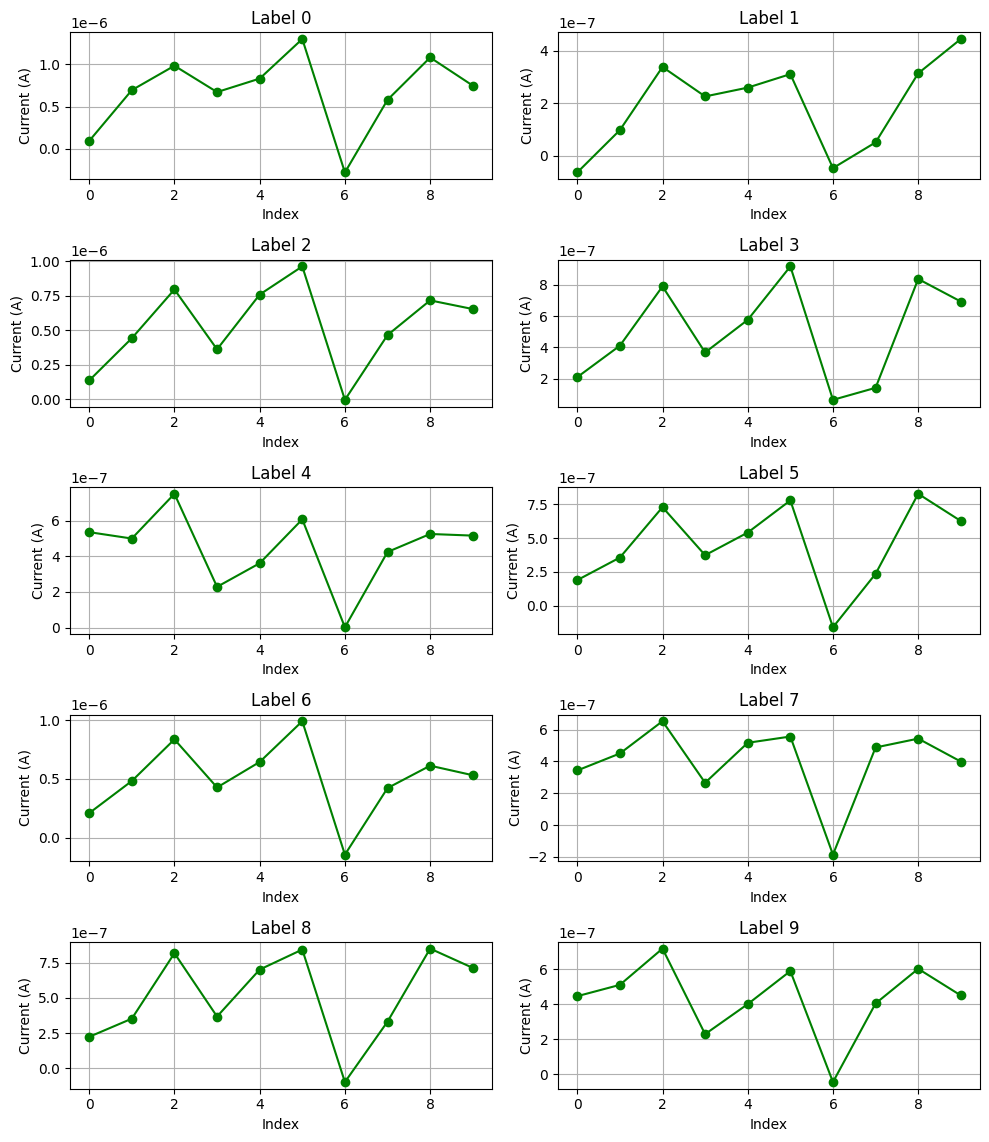

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 데이터 로드
vred_mapping_path = 'vred_mapping_testset_v3.csv'
conductance_positive_path = '2conductance_positive_ann_v3.csv'
conductance_negative_path = '2conductance_negative_ann_v3.csv'

# Load voltage data
voltage_data_df = pd.read_csv(vred_mapping_path, header=None)
labels = voltage_data_df.iloc[0, :]  # 첫 번째 행은 라벨
voltage_values = voltage_data_df.iloc[1:, :].astype(float)  # 나머지 행은 전압 값

# Load conductance data
conductance_positive_df = pd.read_csv(conductance_positive_path, skiprows=[0],header=None).iloc[1:, :]
conductance_negative_df = pd.read_csv(conductance_negative_path, skiprows=[0],header=None).iloc[1:, :]

conductance_positive = conductance_positive_df.values.astype(float)
conductance_negative = conductance_negative_df.values.astype(float)

# 2. 전류 계산 및 저장
current_results = {}
label_outputs = {i: [] for i in range(10)}  # 각 라벨에 대한 결과 저장

for col_idx in range(voltage_values.shape[1]):
    label = int(labels[col_idx])  # 현재 열의 라벨
    voltage_column = voltage_values.iloc[:, col_idx].values  # 열 데이터
    voltage_column = voltage_column[:, np.newaxis]  # 2D 배열로 변환

    # Positive and Negative current 계산
    positive_current = np.sum(voltage_column * conductance_positive, axis=0)
    negative_current = np.sum(voltage_column * conductance_negative, axis=0)

    # Net current 계산
    net_current = positive_current - negative_current
    sample_key = f"sample_{label}_{len(label_outputs[label]) + 1}"
    current_results[sample_key] = net_current
    label_outputs[label].append(net_current)

# 3. 라벨별 평균 전류 계산
label_mean_currents = {}
for label in range(10):
    if label_outputs[label]:
        label_mean_currents[label] = np.mean(label_outputs[label], axis=0)  # 평균 계산

# 4. 시각화
fig, axes = plt.subplots(5, 2, figsize=(10, 12))
#fig.suptitle('Output by Label', fontsize=16)

for i in range(10):
    avg_output = label_mean_currents[i]
    x_indices = range(len(avg_output))  # 인덱스 생성
    ax = axes[i // 2, i % 2]
    ax.plot(x_indices, avg_output, marker='o',color='g')
    ax.set_title(f'Label {i}')
    ax.set_xlabel('Index')
    ax.set_ylabel('Current (A)')
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figure8_result_plot_avg2.png')
print("Plot saved as 'figure8_result_plot_avg2.png'")

